In [2]:
import jax
import jax.numpy as jnp
import optax

goal = jnp.array([2.5, 1.5])
x_obs = jnp.array([2.0, 1.0])  # 2D obstacle position
radius = 0.5  # obstacle radius


def dynamics(x, u, goal=goal):
    """
    2D system dynamics with a goal-seeking component
    """
    assert x.shape == (2,), f"Expected x to be 2D, got {x.shape}"
    assert u.shape == (2,), f"Expected u to be 2D, got {u.shape}"
    f_x = 0.5 * (goal - x)
    return f_x + u

In [3]:
def objective_function(u):
    """Objective function for control effort minimization"""
    return jnp.sum(u**2)


def cbf(x, x_obs=x_obs, radius=radius):
    """
    Barrier function for obstacle avoidance in 2D
    Returns a scalar value representing distance to obstacle minus radius
    """
    return jnp.linalg.norm(x - x_obs) - radius


def cbf_constraint(x, u, alpha=1.0):
    """Barrier function constraint for 2D system"""
    h_x = cbf(x)
    dh_dx = jax.jacfwd(cbf)(x)

    f_x = dynamics(x, jnp.zeros(2))  # f(x) = dx/dt where u = 0

    # Take a derivative of x' = f(x) + g(x)u w.r.t. u
    g_x = jax.jacfwd(lambda u_: dynamics(x, u_))(jnp.zeros(2))

    # Lie derivatives
    lie_f = dh_dx @ f_x
    lie_g = dh_dx @ g_x @ u

    return lie_f + lie_g + alpha * h_x

In [4]:
@jax.jit
def solve_cbf_qp(x0, learning_rate=0.01, u_cutoff=(-10.0, 10.0)):
    """Solves a Control Barrier Function (CBF) Quadratic Program (QP) for 2D system"""
    u_min, u_max = u_cutoff

    def total_loss(u, x0):
        """Total loss function for CBF-QP.
        We use the Lagrange multiplier method for inequality constraints
        """
        constraint_val = -cbf_constraint(x0, u)
        constraint_violation = jnp.maximum(constraint_val, 0.0)
        return objective_function(u) + 1000.0 * jnp.sum(constraint_violation)

    def update(params, opt_state):
        loss, grads = jax.value_and_grad(total_loss)(params, x0)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss

    def scan_body(carry, _):
        """Single iteration of the optimization loop for use with jax.lax.scan"""
        u, opt_state, _ = carry
        u, opt_state, loss = update(u, opt_state)
        u = jnp.clip(u, u_min, u_max)
        return (u, opt_state, loss), loss

    # We use Adam optimizer to solve the QP
    optimizer = optax.adam(learning_rate)
    u = jnp.zeros(2)  # Initial 2D control input
    opt_state = optimizer.init(u)

    init_carry = (u, opt_state, jnp.array(0.0))
    (u, opt_state, loss), losses = jax.lax.scan(
        scan_body,
        init_carry,
        None,
        length=1000,
    )

    return u, loss


# Solve CBF with QP
x0 = jnp.array([0.5, 1.0])  # 2D initial state
u, final_loss = solve_cbf_qp(x0)

print("Control Input (u):", u)
print("Final Loss:", final_loss)
print("CBF Constraint Value:", cbf_constraint(x0, u))

Control Input (u): [-0.0220784  0.       ]
Final Loss: 0.000489101
CBF Constraint Value: 0.022078395


In [5]:
def simulate_system(x0, time_steps=200, dt=0.05):
    """
    Simulate the system dynamics by computing a control signal at each step
    """
    x = x0
    states = [x]
    controls = []

    for _ in range(time_steps):
        # Solve CBF-QP at the current state
        u, _ = solve_cbf_qp(x)
        controls.append(u)

        # Apply control and update state
        x_dot = dynamics(x, u)
        x = x + x_dot * dt
        states.append(x)

        # Check if we're close to the goal
        goal = jnp.array([2.5, 1.5])
        if jnp.linalg.norm(x - goal) < 0.1:
            break

    return jnp.array(states), jnp.array(controls)


states, controls = simulate_system(x0)
print("Final State:", states[-1])
print("Distance to goal:", jnp.linalg.norm(states[-1] - jnp.array([2.5, 1.5])))

Final State: [2.4015396 1.515551 ]
Distance to goal: 0.09968094


In [6]:
# Compute a trajectory that tries to reach the goal without obstacle avoidance
states_noa = [x0]
for _ in range(200):
    u = jnp.zeros(2)
    x_dot = dynamics(states_noa[-1], u)
    x = states_noa[-1] + x_dot * 0.05
    states_noa.append(x)

    if jnp.linalg.norm(x - goal) < 0.1:
        break

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


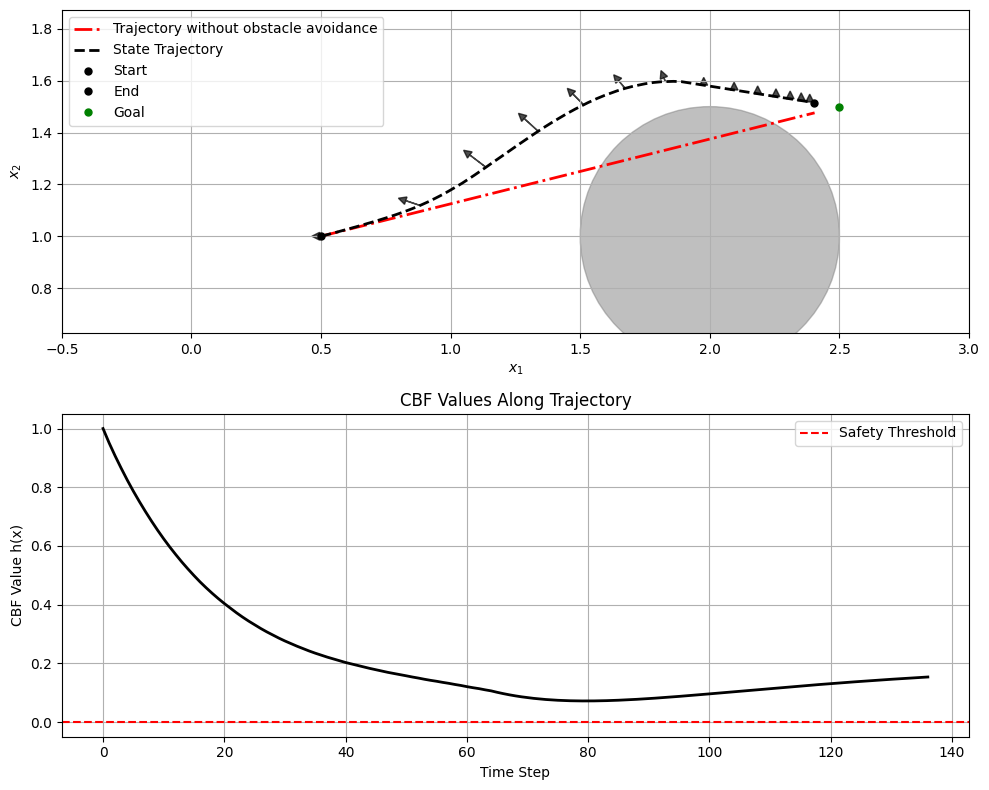

In [7]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Plot the state trajectory without obstacle avoidance
states_noa = jnp.array(states_noa)
axs[0].plot(
    states_noa[:, 0],
    states_noa[:, 1],
    "r-.",
    linewidth=2,
    label="Trajectory without obstacle avoidance",
)

# Plot the state trajectory
axs[0].plot(states[:, 0], states[:, 1], "k--", linewidth=2, label="State Trajectory")
axs[0].plot(x0[0], x0[1], "ko", markersize=5, label="Start")
axs[0].plot(states[-1, 0], states[-1, 1], "ko", markersize=5, label="End")
axs[0].plot(goal[0], goal[1], "go", markersize=5, label="Goal")

# Plot obstacle
circle = plt.Circle((x_obs[0], x_obs[1]), radius, fill=True, color="gray", alpha=0.5)
axs[0].add_patch(circle)

# Plot control vectors at some points
stride = 10
for i in range(0, len(states) - 1, stride):
    if i < len(controls):
        axs[0].arrow(
            states[i, 0],
            states[i, 1],
            controls[i, 0] * 0.25,
            controls[i, 1] * 0.25,
            head_width=0.03,
            head_length=0.03,
            fc="k",
            ec="k",
            alpha=0.7,
        )


axs[0].grid(True)
axs[0].legend()
axs[0].set_xlabel(r"$x_1$")
axs[0].set_ylabel(r"$x_2$")
axs[0].axis("equal")
axs[0].set_xlim(-0.5, 3.0)
axs[0].set_ylim(-0.5, 3.0)

# Plot CBF values over time
cbf_values = jnp.array([cbf(x) for x in states])
axs[1].plot(cbf_values, "k-", linewidth=2)
axs[1].axhline(y=0, color="r", linestyle="--", label="Safety Threshold")
axs[1].grid(True)
axs[1].set_xlabel("Time Step")
axs[1].set_ylabel("CBF Value h(x)")
axs[1].set_title("CBF Values Along Trajectory")
axs[1].legend()

plt.tight_layout()
plt.show()